In [1]:
%matplotlib inline
import numpy as np
import os, glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray
import wrf
import matplotlib.dates as mdates

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from pandas import to_datetime, DataFrame

In [3]:
dataPath = '/glade/scratch/domingom/Cheyenne/XPIA_mesoLES/SIMULS/'
outPath  = '/glade/scratch/doubrawa/postProcessing/'
figPath  = '/glade/u/home/doubrawa/figs/'

In [4]:
domainId     = 4

In [5]:
plt.rc("font",size=14)

In [6]:
z_target = np.arange(10.0, 3000.1, 20.0)

# grab all data

In [21]:
day   = 20
itime = 0

for hour in np.arange(14,24,1):
    for half_hour_idx in [1,2]:
        wrfoutPath  = (glob.glob(os.path.join(dataPath,
                           'WRF_mesoLES_4dom_RAP_2015_03_{0}_mesoLES'.format(day),
                           'HOUR_{0}_{1}'.format(hour,half_hour_idx),
                           'wrfout_d0{0}_*_1180'.format(domainId))))[0]
        print (os.path.split(wrfoutPath)[-1]    )
        wrfnc = Dataset(wrfoutPath)
        time = to_datetime(wrfoutPath.split("_d04_")[-1][:-5],format="%Y-%m-%d_%H:%M:%S")
        
        #
        # these are needed for vertical interpolation
        #
        z        = wrf.getvar(wrfnc, "z", units="m", timeidx=wrf.ALL_TIMES)
        theta    = wrf.getvar(wrfnc, "theta", units="K", timeidx=wrf.ALL_TIMES)
        
        #
        # can't use getvar because file doesn't have XLAT_U
        # also cannot fully destagger because then I would need to read one more patch,
        # since both unstaggered and staggered variables in this patch have the same size,
        # and U doesn't have one more along the x dimension. so set last x to np.nan
        #
        U              = wrfnc["U"]
        u              = np.zeros(U.shape)
        u[:,:,:,0:29]  = 0.5*(U[:,:,:,0:29] + U[:,:,:,1:30])
        u[:,:,:,29]    = np.nan
        u = xarray.DataArray(u,
                     coords={"Time":theta.coords["Time"],"bottom_top":theta.coords["bottom_top"],"south_north":theta.coords["south_north"],"west_east":theta.coords["west_east"]}, 
                     dims=("Time","bottom_top","south_north","west_east"), 
                     name="U", 
                     attrs={"unit":"m s-1","stagger":""})


        #
        # can't use getvar because file doesn't have XLONG_V
        # also cannot fully destagger because then I would need to read one more patch,
        # since both unstaggered and staggered variables in this patch have the same size,
        # and V doesn't have one more along the y dimension. so set last y to np.nan
        #
        V              = wrfnc["V"]
        v              = np.zeros(V.shape)
        v[:,:,0:26,:]  = 0.5*(V[:,:,0:26,:] + V[:,:,1:27,:])
        v[:,:,26,:]    = np.nan
        v = xarray.DataArray(v,
                     coords={"Time":theta.coords["Time"],"bottom_top":theta.coords["bottom_top"],"south_north":theta.coords["south_north"],"west_east":theta.coords["west_east"]}, 
                     dims=("Time","bottom_top","south_north","west_east"), 
                     name="V", 
                     attrs={"unit":"m s-1","stagger":""})   
        
        #
        # temporarily grab other variables to see if they are useful
        #
        hfx  = wrf.getvar(wrfnc, "HFX", timeidx=wrf.ALL_TIMES)
        linv = wrf.getvar(wrfnc, "RMOL", timeidx=wrf.ALL_TIMES)

        #
        # concat along time dimension
        #
        if itime==0:
            theta_final = theta
            z_final = z
            hgt = wrf.getvar(wrfnc, "ter", units="m")
            hfx_final = hfx
            linv_final = linv
            u_final = u
            v_final = v            
        else:
            theta_final = xarray.concat([theta_final,theta],dim="Time")   
            z_final = xarray.concat([z_final,z],dim="Time")   
            hfx_final = xarray.concat([hfx_final,hfx],dim="Time")
            linv_final = xarray.concat([linv_final, linv],dim="Time")
            u_final = xarray.concat([u_final, u],dim="Time")
            v_final = xarray.concat([v_final, v],dim="Time")            

        itime += 1

wrfout_d04_2015-03-21_14:00:10_1180
wrfout_d04_2015-03-21_14:30:10_1180
wrfout_d04_2015-03-21_15:00:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_15:30:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_16:00:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_16:30:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_17:00:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_17:30:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_18:00:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_18:30:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_19:00:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_19:30:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_20:00:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_20:30:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_21:00:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_21:30:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_22:00:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_22:30:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_23:00:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


wrfout_d04_2015-03-21_23:30:10_1180


/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


In [23]:
# use `arr[tuple(seq)]` instead of `arr[seq]`

In [24]:
wind = np.sqrt(u_final**2+v_final**2)

# go from model level to z

In [ ]:
for z_val in z_target: 
    print (z_val)
    
    theta_int = wrf.interplevel(theta_final, z_final-hgt, z_val, meta=True)    
    theta_int['z'] = z_val  
    
    wind_int = wrf.interplevel(wind, z_final-hgt, z_val, meta=True)    
    wind_int['z'] = z_val
    
    if (z_val==z_target[0]):
        theta_z = theta_int
        wind_z  = wind_int
    else:
        theta_z = xarray.concat([theta_z,theta_int],dim='z')   
        wind_z  = xarray.concat([wind_z,wind_int],dim='z')   

# visualize contours

In [10]:
z_vs_time = theta_z.sel(south_north=slice(17,28),west_east=slice(17-5,17+5)).mean(dim=["south_north",'west_east'])

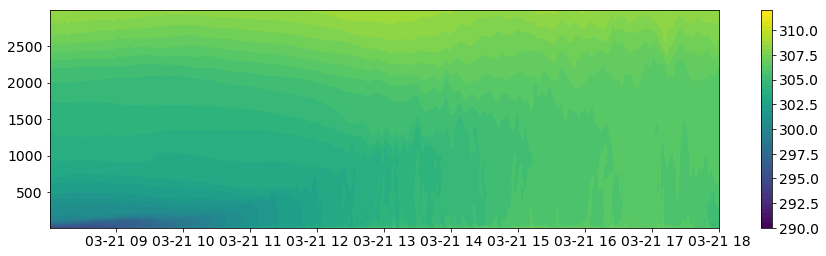

In [11]:
times = to_datetime(z_vs_time.Time.data).tz_localize("UTC").tz_convert("US/Mountain")

fig = plt.figure(figsize=(15,4))
ax  = fig.add_subplot(111)
p = ax.contourf(times,z_vs_time.z.data,z_vs_time.data, levels=np.arange(290,312.1,0.5))
plt.colorbar(p)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

In [12]:
z_vs_time_wind = wind_z.sel(south_north=slice(17,28),west_east=slice(17-5,17+5)).mean(dim=["south_north",'west_east'])

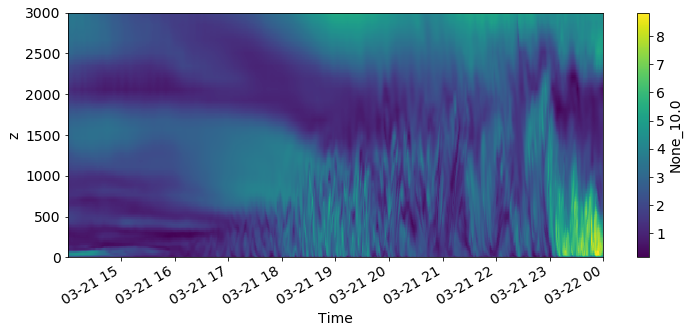

In [13]:
z_vs_time_wind.plot(figsize=(12,5))

# visualize spatially averaged profiles at each time

In [132]:
subsetTimes = theta_final.coords["Time"][::360]

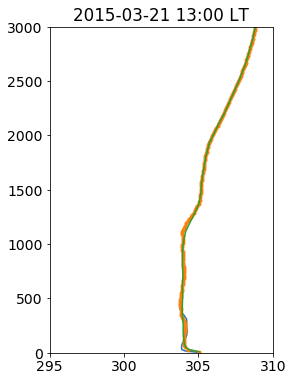

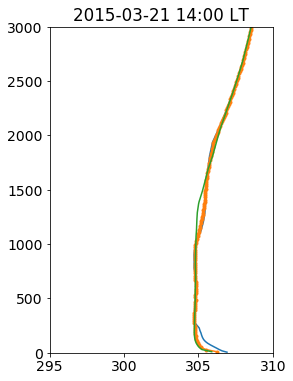

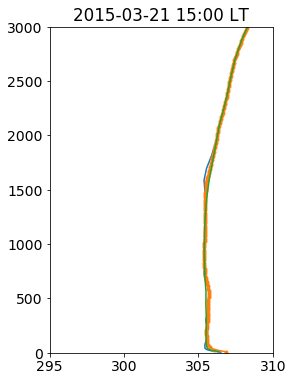

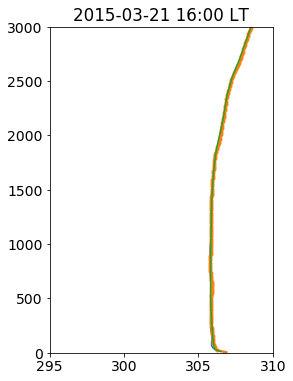

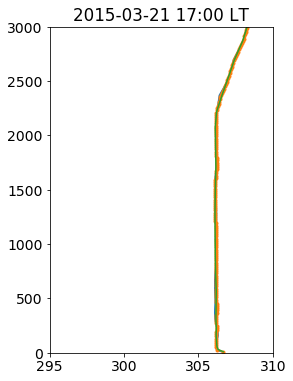

In [133]:
for itime in subsetTimes.data[5:]:
    bao = theta_final.sel(Time=itime).isel(south_north=25).isel(west_east=17)
    bao_x = bao.data
    bao_y = z_final.sel(Time=itime).isel(south_north=25).isel(west_east=17).data-float(hgt.isel(south_north=25).isel(west_east=17).data)

    small_patch = theta_z.sel(Time=itime).sel(south_north=slice(17,27),west_east=slice(17-5,17+5)).mean(dim=["south_north",'west_east'])
    small_x = small_patch.data
    small_y = small_patch.coords['z']

    patch = theta_z.sel(Time=itime).mean(dim=["south_north",'west_east'])
    big_x = patch.data
    big_y = patch.coords['z']
    
    theta_1 = small_x[0]
    indices = (np.where(small_x)-theta_1)>=0.5
    
    local = to_datetime(itime).tz_localize("UTC").tz_convert("US/Mountain")
    
    plt.figure(figsize=(4,6))
    plt.plot(bao_x,bao_y,label='bao')
    plt.plot(small_x,small_y,label='10x10 pts',marker='.')
    plt.plot(big_x,big_y,label='30x27 pts')
    plt.ylim([0,3000])
    plt.xlim([295,310])
    plt.title("{0:%Y-%m-%d %H:%M LT}".format(local))
#     plt.savefig("/glade/u/home/doubrawa/figs/t_profile_{0:%Y-%m-%d-%H-%M}.png".format(to_datetime(itime)))

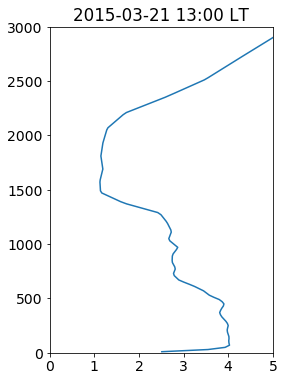

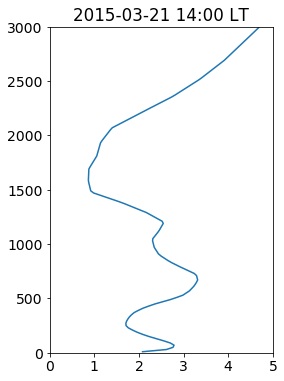

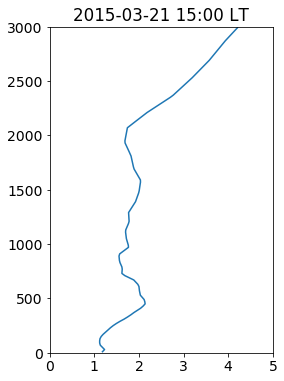

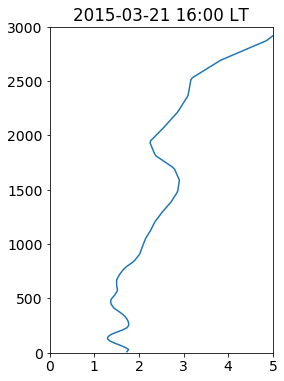

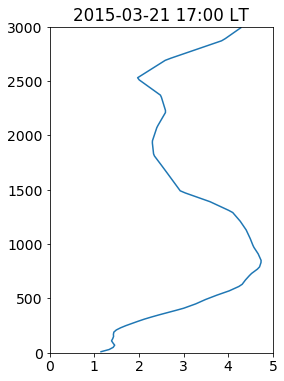

In [136]:
for itime in subsetTimes.data[5:]:
    patch = wind_z.sel(Time=itime).mean(dim=["south_north",'west_east'])
    big_x = patch.data
    big_y = patch.coords['z']
    local = to_datetime(itime).tz_localize("UTC").tz_convert("US/Mountain")
    
    plt.figure(figsize=(4,6))
    plt.plot(big_x,big_y,label='30x27 pts')
    plt.ylim([0,3000])
    plt.xlim([0,5])
    plt.title("{0:%Y-%m-%d %H:%M LT}".format(local))
#     plt.savefig("/glade/u/home/doubrawa/figs/t_profile_{0:%Y-%m-%d-%H-%M}.png".format(to_datetime(itime)))

# method from paper

In [64]:
import pdb

In [138]:
small_patch = theta_z.sel(south_north=slice(17,27),west_east=slice(17-5,17+5)).mean(dim=["south_north",'west_east'])
wind_patch  = wind_z.sel(south_north=slice(17,27),west_east=slice(17-5,17+5)).mean(dim=["south_north",'west_east'])

zi_list = []
regime = []

for itime in range(len(small_patch.Time)):

    print itime
    
    u = wind_patch.isel(Time=itime).data
    t = small_patch.isel(Time=itime).data
    z = small_patch.z.data

    layer_dt  = t[3] - t[0]
    delta_s   = 0.1
    
    delta_u   = 0.25
    lapse_tgt = 4.0

    if layer_dt<-delta_s: 
        num = 3        
        #
        # unstable : Since buoyancy is the dominant mechanism driving
        # turbulence in the CBL, we determine the PBLH as the
        # height at which an air parcel rising adiabatically from the
        # surface becomes neutrally buoyant (Stull 1988).
        #
        
        # step 1: scan upward to find the lowest level where
        #  theta_k - theta_1 >= delta_u
        first_guess_k = np.where((t-t[0])>=delta_u)[0][0]
        t = t[first_guess_k:]
        z = z[first_guess_k:]
        
        # step 2: another upward scan to search for the first
        #  occurrence of lapse >= lapse_r
        lapse = (np.diff(t)/np.diff(z))*1000.0   
        try:
            second_guess_k = np.where(lapse>=lapse_tgt)[0][0]
        except:
            second_guess_k = 0
        zi_val = z[second_guess_k]
        
    elif layer_dt>delta_s: # stable

        num = 1
        break
        curvature_peak = 40

        lapse = (np.diff(t)/np.diff(z))*1000.0        

        for k in range(1,len(t)-1,1):
            #print lapse[k] - lapse[k-1]
            if ((lapse[k] - lapse[k-1]) < (-curvature_peak)):
                print("condition 1")
                print z[k]
                pdb.set_trace()

        zi_val = np.nan
        
    else: # neutral
        num = 2

        
        #
        # unstable : Since buoyancy is the dominant mechanism driving
        # turbulence in the CBL, we determine the PBLH as the
        # height at which an air parcel rising adiabatically from the
        # surface becomes neutrally buoyant (Stull 1988).
        #
        
        # step 1: scan upward to find the lowest level where
        #  theta_k - theta_1 >= delta_u
        first_guess_k = np.where((t-t[0])>=delta_u)[0][0]
        t = t[first_guess_k:]
        z = z[first_guess_k:]
        
        # step 2: another upward scan to search for the first
        #  occurrence of lapse >= lapse_r
        lapse = (np.diff(t)/np.diff(z))*1000.0        
        try:
            second_guess_k = np.where(lapse>=lapse_tgt)[0][0]
        except:
            second_guess_k = first_guess_k
        zi_val = z[second_guess_k]
        
        
    regime.append(num)
    zi_list.append(zi_val)

0


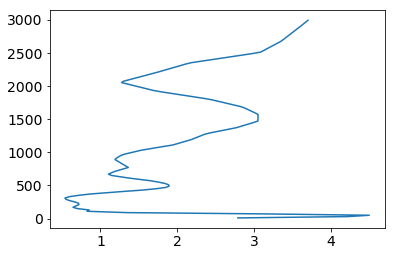

In [139]:
plt.plot(u,z)

In [ ]:
the LLJ nose is identified at the level
where wind speed reaches a maximum that is at least
2 m s21 stronger than the layers above and below while
decreasing monotonically toward the surface

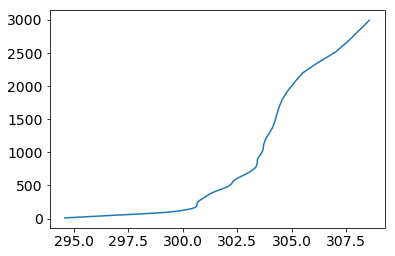

In [43]:
plt.plot(t,z)

In [62]:
curvature_peak = 40

t = small_patch.isel(Time=itime).data[::1]
z = small_patch.z.data[::1]

lapse = (np.diff(t)/np.diff(z))*1000.0        

for k in range(1,len(t)-1,1):
    #print lapse[k] - lapse[k-1]
    if ((lapse[k] - lapse[k-1]) < (-curvature_peak)):
        print("condition 1")
        print z[k]
    

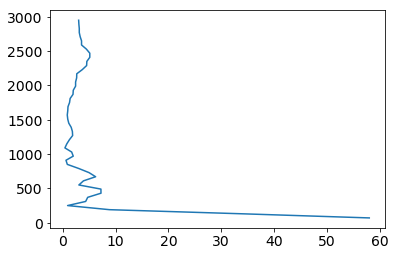

In [54]:
plt.plot(lapse,z[1:])

In [37]:
L = linv_final.sel(south_north=slice(17,27),west_east=slice(17-5,17+5)).mean(dim=["south_north",'west_east'])



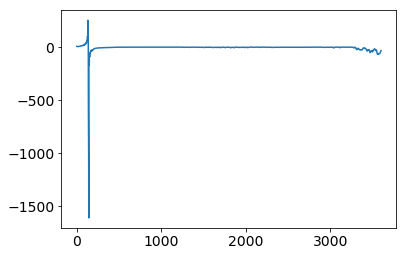

In [39]:
plt.plot(1/L)

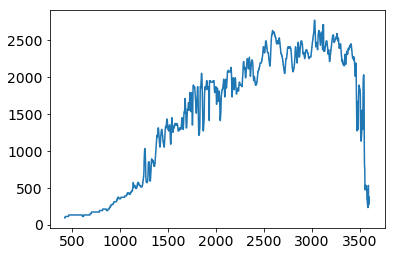

In [32]:
# plt.plot(regime)
plt.plot(zi_list)

In [24]:
    t = small_patch.isel(Time=itime).data
    z = small_patch.z.data

    layer_dt  = t[3] - t[0]
    delta_s   = 0.1
    
    delta_u   = 0.25
    lapse_tgt = 4.0



In [25]:
        first_guess_k = np.where((t-t[0])>=delta_u)[0][0]
        t = t[first_guess_k:]
        z = z[first_guess_k:]

In [26]:
        lapse = (np.diff(t)/np.diff(z))*1000.0        


In [27]:
        second_guess_k = np.where(lapse>=lapse_tgt)[0][0]
        zi_val = z[second_guess_k]




IndexError: index 0 is out of bounds for axis 0 with size 0

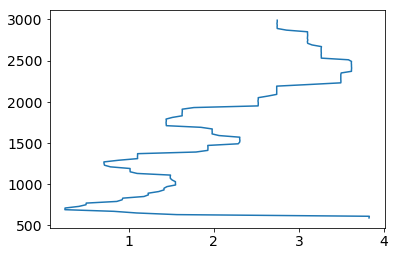

In [29]:
plt.plot(lapse,z[1:])

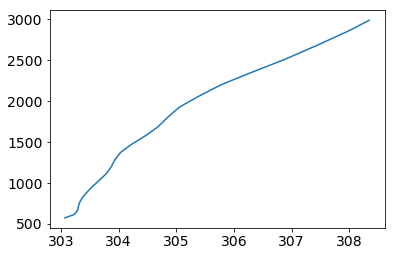

In [22]:
plt.plot(t,z)

In [ ]:
tke profiles?!

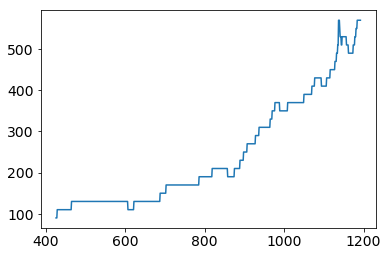

In [16]:
# plt.plot(regime)
plt.plot(zi_list)

In [ ]:
plt.plot(zi)

In [52]:
len(z)

132

In [185]:
np.where(lapse>=lapse_tgt)

array([9.56420898, 7.89489746, 6.60858154, 5.28564453, 4.59594727,
       3.62701416, 3.83300781, 4.64782715, 4.64782715, 2.09503174,
       1.6494751 , 1.12915039, 0.16937256, 0.17089844, 0.42572021,
       0.54016113, 0.53710938, 0.97351074, 1.04064941, 1.04064941,
       1.21307373, 1.24206543, 1.24053955, 1.26800537, 1.28173828,
       1.2802124 , 1.28326416, 1.28479004, 1.28326416, 1.28479004,
       1.34735107, 1.37329102, 1.37481689, 1.37481689, 1.24969482,
       1.22375488, 1.22680664, 1.222229  , 0.99182129, 0.92163086,
       0.92315674, 0.92163086, 0.91552734, 0.90942383, 0.90789795,
       0.90789795, 0.90789795, 1.34735107, 1.4251709 , 1.42364502,
       1.42211914, 1.42364502, 2.05230713, 2.07061768, 2.07061768,
       2.07061768, 2.07061768, 2.07824707, 2.07824707, 2.07824707,
       2.07977295, 2.08129883, 1.91497803, 1.46484375, 1.46179199,
       1.46331787, 1.46484375, 1.46331787, 1.43127441, 1.38549805,
       1.38702393, 1.38397217, 1.38397217, 1.38549805, 1.58538

# algorithmically identify zi

In [11]:
small_patch = theta_z.sel(south_north=slice(17,27),west_east=slice(17-5,17+5)).mean(dim=["south_north",'west_east'])
small_x = small_patch.data
small_y = small_patch.coords['z']

In [12]:
zi = DataFrame(index=small_patch.Time.data,columns=["threshold","max","method"])

In [13]:
for time in zi.index:
    print(time)
    
    profile_theta = small_patch.sel(Time=time).data

    if profile_theta.ndim>1:
        profile_theta = profile_theta[:,0]
        
    profile_z     = small_patch.z.data

    #
    # do not consider points which are in the surface layer
    #
    idx_start = np.where(profile_z>200)[0][0]
    profile_theta = profile_theta[idx_start:]
    profile_z = profile_z[idx_start:]

    #
    # differentiate
    #
    lapse   = (np.diff(profile_theta))/(np.diff(profile_z))
    lapse   = lapse*1000.0

    #
    # first spot where lapse >= 4 K/km
    #
    indices = np.where ( np.round(lapse) >=4 )[0]
    try:
        index_threshold_lapse  = indices[1]
        z_threshold_lapse = profile_z[index_threshold_lapse]
    except:
        z_threshold_lapse = np.nan
    zi.loc[time,"threshold"] = z_threshold_lapse

    #
    # where is lapse maximum
    #
    try:
        index_max_lapse = np.argmax(lapse)
        z_max_lapse = profile_z[index_max_lapse]
    except:
        z_max_lapse = np.nan
    zi.loc[time,"max"] = z_max_lapse
    
    #
    # find segment where potential temperature doesn't change much vertically
    # get the last height of that segment
    # get the profiles starting from that height
    # find maximum lapse rate
    #
    indices = np.where(np.abs(lapse)<0.5)[0]
    try:
        v0 = indices[0]
        for i in range(1,len(indices),1):
            if (indices[i]-v0)>1:
                break
            v0 = indices[i]
        idx = v0 + 1
        z_method = profile_z[idx]
    except:
        z_method = np.nan
    zi.loc[time,"method"] = z_method

2015-03-21 14:00:10
2015-03-21 14:00:20
2015-03-21 14:00:30
2015-03-21 14:00:40
2015-03-21 14:00:50
2015-03-21 14:01:00
2015-03-21 14:01:10
2015-03-21 14:01:20
2015-03-21 14:01:30
2015-03-21 14:01:40
2015-03-21 14:01:50
2015-03-21 14:02:00
2015-03-21 14:02:10
2015-03-21 14:02:20
2015-03-21 14:02:30
2015-03-21 14:02:40
2015-03-21 14:02:50
2015-03-21 14:03:00
2015-03-21 14:03:10
2015-03-21 14:03:20
2015-03-21 14:03:30
2015-03-21 14:03:40
2015-03-21 14:03:50
2015-03-21 14:04:00
2015-03-21 14:04:10
2015-03-21 14:04:20
2015-03-21 14:04:30
2015-03-21 14:04:40
2015-03-21 14:04:50
2015-03-21 14:05:00
2015-03-21 14:05:10
2015-03-21 14:05:20
2015-03-21 14:05:30
2015-03-21 14:05:40
2015-03-21 14:05:50
2015-03-21 14:06:00
2015-03-21 14:06:10
2015-03-21 14:06:20
2015-03-21 14:06:30
2015-03-21 14:06:40
2015-03-21 14:06:50
2015-03-21 14:07:00
2015-03-21 14:07:10
2015-03-21 14:07:20
2015-03-21 14:07:30
2015-03-21 14:07:40
2015-03-21 14:07:50
2015-03-21 14:08:00
2015-03-21 14:08:10
2015-03-21 14:08:20


2015-03-21 15:09:30
2015-03-21 15:09:40
2015-03-21 15:09:50
2015-03-21 15:10:00
2015-03-21 15:10:10
2015-03-21 15:10:20
2015-03-21 15:10:30
2015-03-21 15:10:40
2015-03-21 15:10:50
2015-03-21 15:11:00
2015-03-21 15:11:10
2015-03-21 15:11:20
2015-03-21 15:11:30
2015-03-21 15:11:40
2015-03-21 15:11:50
2015-03-21 15:12:00
2015-03-21 15:12:10
2015-03-21 15:12:20
2015-03-21 15:12:30
2015-03-21 15:12:40
2015-03-21 15:12:50
2015-03-21 15:13:00
2015-03-21 15:13:10
2015-03-21 15:13:20
2015-03-21 15:13:30
2015-03-21 15:13:40
2015-03-21 15:13:50
2015-03-21 15:14:00
2015-03-21 15:14:10
2015-03-21 15:14:20
2015-03-21 15:14:30
2015-03-21 15:14:40
2015-03-21 15:14:50
2015-03-21 15:15:00
2015-03-21 15:15:10
2015-03-21 15:15:20
2015-03-21 15:15:30
2015-03-21 15:15:40
2015-03-21 15:15:50
2015-03-21 15:16:00
2015-03-21 15:16:10
2015-03-21 15:16:20
2015-03-21 15:16:30
2015-03-21 15:16:40
2015-03-21 15:16:50
2015-03-21 15:17:00
2015-03-21 15:17:10
2015-03-21 15:17:20
2015-03-21 15:17:30
2015-03-21 15:17:40


2015-03-21 16:18:50
2015-03-21 16:19:00
2015-03-21 16:19:10
2015-03-21 16:19:20
2015-03-21 16:19:30
2015-03-21 16:19:40
2015-03-21 16:19:50
2015-03-21 16:20:00
2015-03-21 16:20:10
2015-03-21 16:20:20
2015-03-21 16:20:30
2015-03-21 16:20:40
2015-03-21 16:20:50
2015-03-21 16:21:00
2015-03-21 16:21:10
2015-03-21 16:21:20
2015-03-21 16:21:30
2015-03-21 16:21:40
2015-03-21 16:21:50
2015-03-21 16:22:00
2015-03-21 16:22:10
2015-03-21 16:22:20
2015-03-21 16:22:30
2015-03-21 16:22:40
2015-03-21 16:22:50
2015-03-21 16:23:00
2015-03-21 16:23:10
2015-03-21 16:23:20
2015-03-21 16:23:30
2015-03-21 16:23:40
2015-03-21 16:23:50
2015-03-21 16:24:00
2015-03-21 16:24:10
2015-03-21 16:24:20
2015-03-21 16:24:30
2015-03-21 16:24:40
2015-03-21 16:24:50
2015-03-21 16:25:00
2015-03-21 16:25:10
2015-03-21 16:25:20
2015-03-21 16:25:30
2015-03-21 16:25:40
2015-03-21 16:25:50
2015-03-21 16:26:00
2015-03-21 16:26:10
2015-03-21 16:26:20
2015-03-21 16:26:30
2015-03-21 16:26:40
2015-03-21 16:26:50
2015-03-21 16:27:00


2015-03-21 17:35:20
2015-03-21 17:35:30
2015-03-21 17:35:40
2015-03-21 17:35:50
2015-03-21 17:36:00
2015-03-21 17:36:10
2015-03-21 17:36:20
2015-03-21 17:36:30
2015-03-21 17:36:40
2015-03-21 17:36:50
2015-03-21 17:37:00
2015-03-21 17:37:10
2015-03-21 17:37:20
2015-03-21 17:37:30
2015-03-21 17:37:40
2015-03-21 17:37:50
2015-03-21 17:38:00
2015-03-21 17:38:10
2015-03-21 17:38:20
2015-03-21 17:38:30
2015-03-21 17:38:40
2015-03-21 17:38:50
2015-03-21 17:39:00
2015-03-21 17:39:10
2015-03-21 17:39:20
2015-03-21 17:39:30
2015-03-21 17:39:40
2015-03-21 17:39:50
2015-03-21 17:40:00
2015-03-21 17:40:10
2015-03-21 17:40:20
2015-03-21 17:40:30
2015-03-21 17:40:40
2015-03-21 17:40:50
2015-03-21 17:41:00
2015-03-21 17:41:10
2015-03-21 17:41:20
2015-03-21 17:41:30
2015-03-21 17:41:40
2015-03-21 17:41:50
2015-03-21 17:42:00
2015-03-21 17:42:10
2015-03-21 17:42:20
2015-03-21 17:42:30
2015-03-21 17:42:40
2015-03-21 17:42:50
2015-03-21 17:43:00
2015-03-21 17:43:10
2015-03-21 17:43:20
2015-03-21 17:43:30


2015-03-21 18:51:10
2015-03-21 18:51:20
2015-03-21 18:51:30
2015-03-21 18:51:40
2015-03-21 18:51:50
2015-03-21 18:52:00
2015-03-21 18:52:10
2015-03-21 18:52:20
2015-03-21 18:52:30
2015-03-21 18:52:40
2015-03-21 18:52:50
2015-03-21 18:53:00
2015-03-21 18:53:10
2015-03-21 18:53:20
2015-03-21 18:53:30
2015-03-21 18:53:40
2015-03-21 18:53:50
2015-03-21 18:54:00
2015-03-21 18:54:10
2015-03-21 18:54:20
2015-03-21 18:54:30
2015-03-21 18:54:40
2015-03-21 18:54:50
2015-03-21 18:55:00
2015-03-21 18:55:10
2015-03-21 18:55:20
2015-03-21 18:55:30
2015-03-21 18:55:40
2015-03-21 18:55:50
2015-03-21 18:56:00
2015-03-21 18:56:10
2015-03-21 18:56:20
2015-03-21 18:56:30
2015-03-21 18:56:40
2015-03-21 18:56:50
2015-03-21 18:57:00
2015-03-21 18:57:10
2015-03-21 18:57:20
2015-03-21 18:57:30
2015-03-21 18:57:40
2015-03-21 18:57:50
2015-03-21 18:58:00
2015-03-21 18:58:10
2015-03-21 18:58:20
2015-03-21 18:58:30
2015-03-21 18:58:40
2015-03-21 18:58:50
2015-03-21 18:59:00
2015-03-21 18:59:10
2015-03-21 18:59:20


2015-03-21 20:06:00
2015-03-21 20:06:10
2015-03-21 20:06:20
2015-03-21 20:06:30
2015-03-21 20:06:40
2015-03-21 20:06:50
2015-03-21 20:07:00
2015-03-21 20:07:10
2015-03-21 20:07:20
2015-03-21 20:07:30
2015-03-21 20:07:40
2015-03-21 20:07:50
2015-03-21 20:08:00
2015-03-21 20:08:10
2015-03-21 20:08:20
2015-03-21 20:08:30
2015-03-21 20:08:40
2015-03-21 20:08:50
2015-03-21 20:09:00
2015-03-21 20:09:10
2015-03-21 20:09:20
2015-03-21 20:09:30
2015-03-21 20:09:40
2015-03-21 20:09:50
2015-03-21 20:10:00
2015-03-21 20:10:10
2015-03-21 20:10:20
2015-03-21 20:10:30
2015-03-21 20:10:40
2015-03-21 20:10:50
2015-03-21 20:11:00
2015-03-21 20:11:10
2015-03-21 20:11:20
2015-03-21 20:11:30
2015-03-21 20:11:40
2015-03-21 20:11:50
2015-03-21 20:12:00
2015-03-21 20:12:10
2015-03-21 20:12:20
2015-03-21 20:12:30
2015-03-21 20:12:40
2015-03-21 20:12:50
2015-03-21 20:13:00
2015-03-21 20:13:10
2015-03-21 20:13:20
2015-03-21 20:13:30
2015-03-21 20:13:40
2015-03-21 20:13:50
2015-03-21 20:14:00
2015-03-21 20:14:10


2015-03-21 21:19:30
2015-03-21 21:19:40
2015-03-21 21:19:50
2015-03-21 21:20:00
2015-03-21 21:20:10
2015-03-21 21:20:20
2015-03-21 21:20:30
2015-03-21 21:20:40
2015-03-21 21:20:50
2015-03-21 21:21:00
2015-03-21 21:21:10
2015-03-21 21:21:20
2015-03-21 21:21:30
2015-03-21 21:21:40
2015-03-21 21:21:50
2015-03-21 21:22:00
2015-03-21 21:22:10
2015-03-21 21:22:20
2015-03-21 21:22:30
2015-03-21 21:22:40
2015-03-21 21:22:50
2015-03-21 21:23:00
2015-03-21 21:23:10
2015-03-21 21:23:20
2015-03-21 21:23:30
2015-03-21 21:23:40
2015-03-21 21:23:50
2015-03-21 21:24:00
2015-03-21 21:24:10
2015-03-21 21:24:20
2015-03-21 21:24:30
2015-03-21 21:24:40
2015-03-21 21:24:50
2015-03-21 21:25:00
2015-03-21 21:25:10
2015-03-21 21:25:20
2015-03-21 21:25:30
2015-03-21 21:25:40
2015-03-21 21:25:50
2015-03-21 21:26:00
2015-03-21 21:26:10
2015-03-21 21:26:20
2015-03-21 21:26:30
2015-03-21 21:26:40
2015-03-21 21:26:50
2015-03-21 21:27:00
2015-03-21 21:27:10
2015-03-21 21:27:20
2015-03-21 21:27:30
2015-03-21 21:27:40


2015-03-21 22:32:50
2015-03-21 22:33:00
2015-03-21 22:33:10
2015-03-21 22:33:20
2015-03-21 22:33:30
2015-03-21 22:33:40
2015-03-21 22:33:50
2015-03-21 22:34:00
2015-03-21 22:34:10
2015-03-21 22:34:20
2015-03-21 22:34:30
2015-03-21 22:34:40
2015-03-21 22:34:50
2015-03-21 22:35:00
2015-03-21 22:35:10
2015-03-21 22:35:20
2015-03-21 22:35:30
2015-03-21 22:35:40
2015-03-21 22:35:50
2015-03-21 22:36:00
2015-03-21 22:36:10
2015-03-21 22:36:20
2015-03-21 22:36:30
2015-03-21 22:36:40
2015-03-21 22:36:50
2015-03-21 22:37:00
2015-03-21 22:37:10
2015-03-21 22:37:20
2015-03-21 22:37:30
2015-03-21 22:37:40
2015-03-21 22:37:50
2015-03-21 22:38:00
2015-03-21 22:38:10
2015-03-21 22:38:20
2015-03-21 22:38:30
2015-03-21 22:38:40
2015-03-21 22:38:50
2015-03-21 22:39:00
2015-03-21 22:39:10
2015-03-21 22:39:20
2015-03-21 22:39:30
2015-03-21 22:39:40
2015-03-21 22:39:50
2015-03-21 22:40:00
2015-03-21 22:40:10
2015-03-21 22:40:20
2015-03-21 22:40:30
2015-03-21 22:40:40
2015-03-21 22:40:50
2015-03-21 22:41:00


2015-03-21 23:44:50
2015-03-21 23:45:00
2015-03-21 23:45:10
2015-03-21 23:45:20
2015-03-21 23:45:30
2015-03-21 23:45:40
2015-03-21 23:45:50
2015-03-21 23:46:00
2015-03-21 23:46:10
2015-03-21 23:46:20
2015-03-21 23:46:30
2015-03-21 23:46:40
2015-03-21 23:46:50
2015-03-21 23:47:00
2015-03-21 23:47:10
2015-03-21 23:47:20
2015-03-21 23:47:30
2015-03-21 23:47:40
2015-03-21 23:47:50
2015-03-21 23:48:00
2015-03-21 23:48:10
2015-03-21 23:48:20
2015-03-21 23:48:30
2015-03-21 23:48:40
2015-03-21 23:48:50
2015-03-21 23:49:00
2015-03-21 23:49:10
2015-03-21 23:49:20
2015-03-21 23:49:30
2015-03-21 23:49:40
2015-03-21 23:49:50
2015-03-21 23:50:00
2015-03-21 23:50:10
2015-03-21 23:50:20
2015-03-21 23:50:30
2015-03-21 23:50:40
2015-03-21 23:50:50
2015-03-21 23:51:00
2015-03-21 23:51:10
2015-03-21 23:51:20
2015-03-21 23:51:30
2015-03-21 23:51:40
2015-03-21 23:51:50
2015-03-21 23:52:00
2015-03-21 23:52:10
2015-03-21 23:52:20
2015-03-21 23:52:30
2015-03-21 23:52:40
2015-03-21 23:52:50
2015-03-21 23:53:00


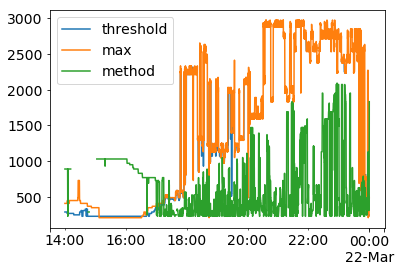

In [15]:
zi.plot()

# debug

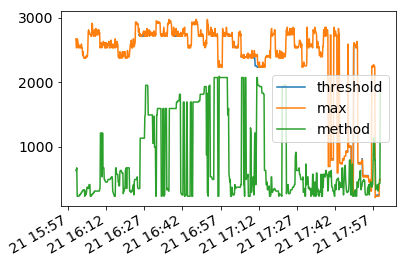

In [24]:
zi.loc['2015-03-21 16:00':'2015-03-21 19:00'].plot()

# continue

In [16]:
zi.index = zi.index.tz_localize("UTC").tz_convert("US/Mountain")

In [17]:
resampled = zi["max"].astype("float").resample("10min").mean().copy()
resampled = resampled.interpolate()

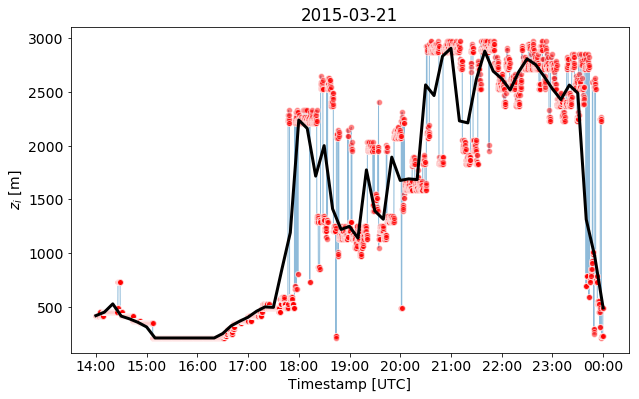

In [18]:
fig = plt.figure(figsize=(10,6))
ax  = fig.add_subplot(111)
ax.plot(zi["max"], '-o', mfc='r', mec='w', alpha=0.5, lw=1)
ax.plot(resampled,'-k', lw=3)
ax.set_ylabel("$z_i$ [m]")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel("Timestamp [UTC]")
ax.set_title("{0:%Y-%m-%d}".format(zi.index[0]))
fig.savefig(os.path.join(figPath,'LES_25m_zi_10x10_{0:%Y_%m_%d}.png'.format(zi.index[0])))

# save it

In [20]:
resampled.to_csv(os.path.join(outPath,'LES_25m_zi_10x10_{0:%Y_%m_%d}.csv'.format(zi.index[0])))